# Validation of ERA5 fluxes: daily average

in this notebook:
- validates ERA5 fluxes for 00 and 12 UTC, calculates daily average fluxes and validates them as well
- note: version for midterm webinar, without time shift to local time

results:
- 12 UTC correlation better than 00 UTC, bias higher for 12 UTC than 00 UTC (since we look at absolute values)
- daily average values correlate really well, better than the ones for single hours

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import pandas as pd
import numpy as np
import glob
import metview as mv
import xarray as xr
execfile("utils.py")
%matplotlib inline

colorpal=["midnightblue","mediumblue","green","greenyellow","yellow",
         "gold","orange","red","darkorchid","darkviolet","blueviolet","indigo"]

In [2]:
#model data directory
dir="/home/lauracma/Documents/ecmwf_proj/data/model_fluxes/analysis_data/raw_data/0001_ea/2020/"
files=np.sort(glob.glob(dir+"/*"))

#obs data
dir_obs="/home/lauracma/Documents/ecmwf_proj/data/ISMN_data/in_situ_data/pre_processed_data/ICOS_FLUXNET/2020/"

#meta data ICOS stations 2020
meta=np.loadtxt("/home/lauracma/Documents/ecmwf_proj/data/ISMN_data/in_situ_data/pre_processed_data/station_info/ICOS_FLUXNET/station_coords_2020",
                str, comments="%", skiprows=1)
meta

array([['BE-Bra', '51.30761', '4.51984', '16', 'Cfb', '3'],
       ['BE-Vie', '50.304962', '5.998099', '490', 'Cfb', '18'],
       ['DE-Tha', '50.96256', '13.56515', '380', 'Cfb', '3'],
       ['DK-Sor', '55.48587', '11.644645', '40', 'Cfb', '5'],
       ['FI-Hyy', '61.84741', '24.29477', '181', 'Dfc', '3'],
       ['CH-Dav', '46.81533', '9.85591', '1689', 'Dfc', '3'],
       ['RU-Fyo', '56.461528', '32.922083', '274', 'Dfc', '3'],
       ['IT-Ren', '46.58686', '11.43369', '1735', 'Dfc', '3'],
       ['DE-Hai', '51.079407', '10.452089', '438', 'Dfb', '6'],
       ['IL-Yat', '31.345045', '35.051989', '657', 'Dfb', '6'],
       ['DE-Geb', '51.09973', '10.91463', '161', 'Cfb', '1'],
       ['SE-Deg', '64.18203', '19.55654', '270', 'Dfc', '13'],
       ['IT-Lav', '45.9562', '11.28132', '1355', 'Dfc', '3'],
       ['BE-Lon', '50.55162', '4.746234', '170', 'Cfb', '1'],
       ['CH-Lae', '47.47808', '8.365', '689', 'Dfc', '3'],
       ['CH-Oe2', '47.28631', '7.73433', '452', 'Dfb', '1'],
    

## Validating all stations per year

In [3]:
#prepare model data
sh=mv.Fieldset()
lh=mv.Fieldset()
monlen=[31,29,31,30,31,30,31,31,30,31,30,31]
for i in range(12):
    print("month: "+str(i+1))
    tmp=mv.read(files[i]) #read model per month
    sh_tmp=tmp["sshf"]
    lh_tmp=tmp["slhf"]
    sh.append(sh_tmp[:monlen[i]*26]) #26 because of the deacc values
    lh.append(lh_tmp[:monlen[i]*26])

month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12


In [5]:
nstations=np.shape(meta)[0]
#sh
sh_cors00=np.zeros(nstations)
sh_cors06=np.zeros(nstations)
sh_cors12=np.zeros(nstations)
sh_cors18=np.zeros(nstations)
sh_cors_day_av=np.zeros(nstations)
sh_md_day_av=np.zeros(nstations)
sh_md12=np.zeros(nstations)
sh_md00=np.zeros(nstations)
#lh
lh_cors00=np.zeros(nstations)
lh_cors06=np.zeros(nstations)
lh_cors12=np.zeros(nstations)
lh_cors18=np.zeros(nstations)
lh_cors_day_av=np.zeros(nstations)
lh_md_day_av=np.zeros(nstations)
lh_md12=np.zeros(nstations)
lh_md00=np.zeros(nstations)

In [6]:
#go through stations
for i in range(nstations):
    meta_station=meta[i,]
    lat=float(meta_station[1])
    lon=float(meta_station[2])
    coords=[lat,lon]
    print("station #"+str(i))
    try:
        f=glob.glob(dir_obs+"/ICOS_FLUXNET_"+str(round(lat,4))+"*"+str(round(lon,4))+"*")
        dat=pd.read_pickle(f[0])
        sh_obs=dat["H_CORR"]
        lh_obs=dat["LE_CORR"]
        #nearest neighbor
        sh_mod=np.array(sh.nearest_gridpoint(coords))/3600*-1
        lh_mod=np.array(lh.nearest_gridpoint(coords))/3600*-1
        #remove artificial zeros
        sh_mod=sh_mod[sh_mod!=0]
        lh_mod=lh_mod[lh_mod!=0]
        #calc daily average
        sh_mod_av, lh_mod_av = era_daily_av(sh_mod,lh_mod)
        sh_obs_av, lh_obs_av = obs_daily_av(sh_obs,lh_obs)
        sh_cors_day_av[i]=np.corrcoef(sh_mod_av,sh_obs_av)[0,1]
        lh_cors_day_av[i]=np.corrcoef(lh_mod_av,lh_obs_av)[0,1]
        sh_md_day_av[i]=np.nanmean(sh_mod_av-sh_obs_av)
        lh_md_day_av[i]=np.nanmean(lh_mod_av-lh_obs_av)
        #per hour
        sh_cors00[i]=np.corrcoef(sh_mod[0:np.shape(sh_mod)[0]:24],sh_obs[0::48])[0,1]
        sh_cors06[i]=np.corrcoef(sh_mod[6:np.shape(sh_mod)[0]:24],sh_obs[12::48])[0,1]
        sh_cors12[i]=np.corrcoef(sh_mod[12:np.shape(sh_mod)[0]:24],sh_obs[24::48])[0,1]
        sh_cors18[i]=np.corrcoef(sh_mod[18:np.shape(sh_mod)[0]:24],sh_obs[36::48])[0,1]
        lh_cors00[i]=np.corrcoef(lh_mod[0:np.shape(lh_mod)[0]:24],lh_obs[0::48])[0,1]
        lh_cors06[i]=np.corrcoef(lh_mod[6:np.shape(lh_mod)[0]:24],lh_obs[12::48])[0,1]
        lh_cors12[i]=np.corrcoef(lh_mod[12:np.shape(lh_mod)[0]:24],lh_obs[24::48])[0,1]
        lh_cors18[i]=np.corrcoef(lh_mod[18:np.shape(lh_mod)[0]:24],lh_obs[36::48])[0,1]
        #mean deviation per hours
        sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
        sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
        lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
        lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])
    except:
        continue

station #0


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #1


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])


station #2
station #3


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #4


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #5


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #6
station #7
station #8
station #9
station #10
station #11
station #12


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #13


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #14


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #15


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #16
station #17
station #18
station #19
station #20
station #21


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #22
station #23
station #24


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #25
station #26


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #27
station #28


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #29
station #30


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #31
station #32
station #33
station #34


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #35
station #36
station #37


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])


station #38


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #39
station #40
station #41
station #42


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #43
station #44
station #45
station #46
station #47
station #48
station #49
station #50
station #51
station #52
station #53


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #54
station #55
station #56
station #57
station #58


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #59


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #60
station #61
station #62


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #63


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #64


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #65
station #66


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #67
station #68


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #69


utils.py:108: RuntimeWarning: Mean of empty slice
  sh_av_obs[int((i+48)/48)]=np.nanmean(sh_obs[i:i+48:2])
utils.py:109: RuntimeWarning: Mean of empty slice
  lh_av_obs[int((i+48)/48)]=np.nanmean(lh_obs[i:i+48:2])
/tmp/ipykernel_59506/2915610606.py:36: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod[12:np.shape(sh_mod)[0]:24]-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:37: RuntimeWarning: Mean of empty slice
  sh_md00[i]=np.nanmean(sh_mod[0:np.shape(sh_mod)[0]:24]-sh_obs[0:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:38: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod[12:np.shape(lh_mod)[0]:24]-lh_obs[24:np.shape(lh_obs)[0]:48])
/tmp/ipykernel_59506/2915610606.py:39: RuntimeWarning: Mean of empty slice
  lh_md00[i]=np.nanmean(lh_mod[0:np.shape(lh_mod)[0]:24]-lh_obs[0:np.shape(lh_obs)[0]:48])


station #70


In [8]:
print("SH correlation 00 UTC: \t\t" + str(np.nanmean(sh_cors00)))
print("SH correlation 12 UTC: \t\t" + str(np.nanmean(sh_cors12)))
print("SH correlation daily average: \t " + str(np.nanmean(sh_cors_day_av)))
print("\n")
print("SH bias 00 UTC: \t\t" + str(np.nanmean(sh_md00)))
print("SH bias 12 UTC: \t\t" + str(np.nanmean(sh_md12)))
print("SH bias daily average: \t " + str(np.nanmean(sh_md_day_av)))
print("\n")
print("LH correlation 00 UTC: \t\t" + str(np.nanmean(lh_cors00)))
print("LH correlation 12 UTC: \t\t" + str(np.nanmean(lh_cors12)))
print("LH correlation daily average: \t " + str(np.nanmean(lh_cors_day_av)))
print("\n")
print("LH bias 00 UTC: \t\t" + str(np.nanmean(lh_md00)))
print("LH bias 12 UTC: \t\t" + str(np.nanmean(lh_md12)))
print("LH bias daily average: \t " + str(np.nanmean(lh_md_day_av)))

SH correlation 00 UTC: 		-0.0020365962409888624
SH correlation 12 UTC: 		0.12226370258618013
SH correlation daily average: 	 0.6774530328929672


SH bias 00 UTC: 		34.46455242131854
SH bias 12 UTC: 		-164.4078726328054
SH bias daily average: 	 -9.860545715167284


LH correlation 00 UTC: 		0.13409364644337549
LH correlation 12 UTC: 		0.23187878180776914
LH correlation daily average: 	 0.674540034787473


LH bias 00 UTC: 		27.86762140045509
LH bias 12 UTC: 		-100.5111056058852
LH bias daily average: 	 -0.781418005435177


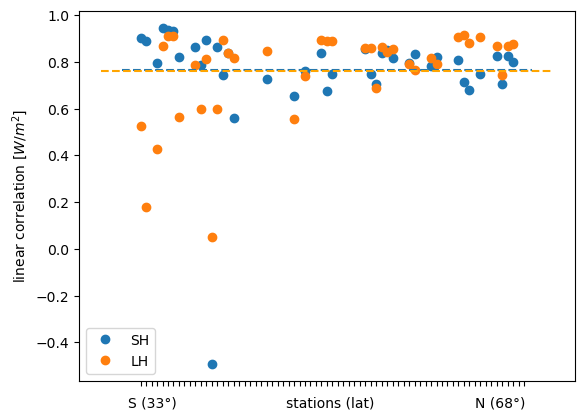

In [9]:
#linear correlation daily average
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_cors_day_av[sh_cors_day_av==0]='nan'
lh_cors_day_av[lh_cors_day_av==0]='nan'
ax.plot(x,sh_cors_day_av[np.argsort(meta[:,1])],"o",label="SH")
ax.plot(x,lh_cors_day_av[np.argsort(meta[:,1])],"o",label="LH")
ax.axes.set_ylabel(r'linear correlation [$W/m^2$]')
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend()
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_cors_day_av[sh_cors_day_av!=0]),col='#1f77b4')
abline(0,np.nanmean(lh_cors_day_av[lh_cors_day_av!=0]),col="orange")
#ax.set_ylim((0.37,1))

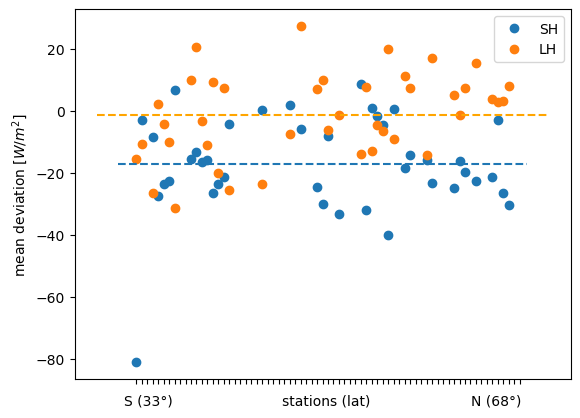

In [10]:
#bias daily average
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_md_day_av[sh_md_day_av==0]='nan'
lh_md_day_av[lh_md_day_av==0]='nan'
ax.plot(x,sh_md_day_av[np.argsort(meta[:,1])],"o",label="SH")
ax.plot(x,lh_md_day_av[np.argsort(meta[:,1])],"o",label="LH")
ax.axes.set_ylabel(r'mean deviation [$W/m^2$]')
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend()
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_md_day_av[sh_md_day_av!=0]),col='#1f77b4')
abline(0,np.nanmean(lh_md_day_av[lh_md_day_av!=0]),col="orange")
#ax.set_ylim((0.37,1))


(-0.4, 0.8)

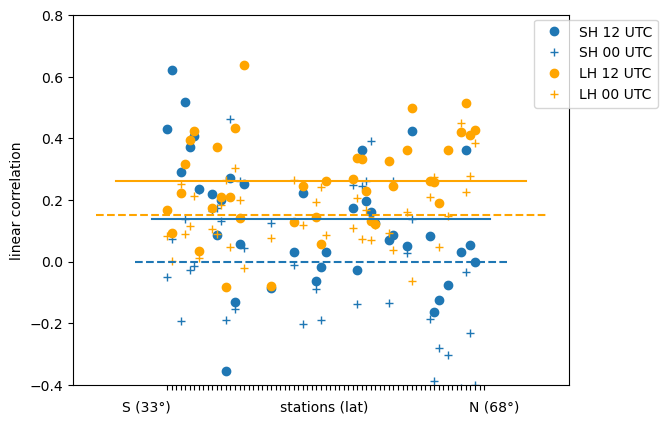

In [11]:
#correlation 00 and 12 utc
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_cors12[sh_cors12==0]='nan'
sh_cors00[sh_cors00==0]='nan'
lh_cors12[lh_cors12==0]='nan'
lh_cors00[lh_cors00==0]='nan'
#ax.plot(x,sh_cors18[np.argsort(meta[:,1])],"x",label="SH 18 UTC",color='#1f77b4')
ax.plot(x,sh_cors12[np.argsort(meta[:,1])],"o",label="SH 12 UTC",color='#1f77b4')
ax.plot(x,sh_cors00[np.argsort(meta[:,1])],"+",label="SH 00 UTC",color='#1f77b4')
#ax.plot(x,lh_cors18[np.argsort(meta[:,1])],"x",label="LH 18 UTC",color='orange')
ax.plot(x,lh_cors12[np.argsort(meta[:,1])],"o",label="LH 12 UTC",color='orange')
ax.plot(x,lh_cors00[np.argsort(meta[:,1])],"+",label="LH 00 UTC",color='orange')
ax.axes.set_ylabel("linear correlation")
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend(loc=(0.93,0.75))
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_cors12),lty="-",col='#1f77b4')
abline(0,np.nanmean(sh_cors00),col='#1f77b4')
abline(0,np.nanmean(lh_cors12),lty="-",col='orange')
abline(0,np.nanmean(lh_cors00),col='orange')
ax.set_ylim((-0.4,0.8))

(-230.0, 50.0)

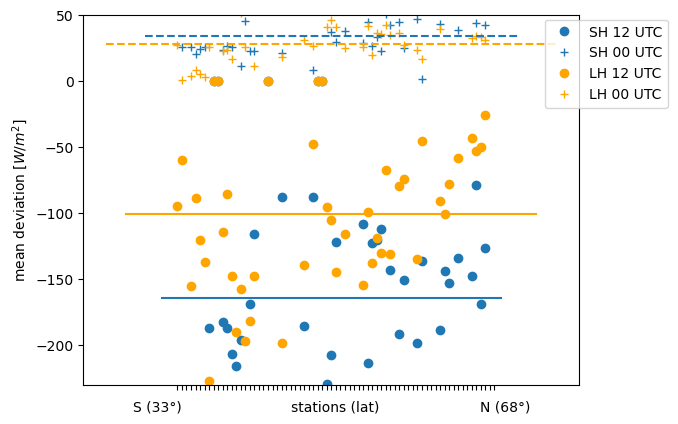

In [12]:
#bias 00 and 12 utc
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_md12[sh_cors12==0]='nan'
sh_md00[sh_cors00==0]='nan'
lh_md12[lh_cors12==0]='nan'
lh_md00[lh_cors00==0]='nan'
ax.plot(x,sh_md12[np.argsort(meta[:,1])],"o",label="SH 12 UTC",color='#1f77b4')
ax.plot(x,sh_md00[np.argsort(meta[:,1])],"+",label="SH 00 UTC",color='#1f77b4')
ax.plot(x,lh_md12[np.argsort(meta[:,1])],"o",label="LH 12 UTC",color='orange')
ax.plot(x,lh_md00[np.argsort(meta[:,1])],"+",label="LH 00 UTC",color='orange')
ax.axes.set_ylabel(r"mean deviation [$W/m^2$]")
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend(loc=(0.93,0.75))
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_md12),lty="-",col='#1f77b4')
abline(0,np.nanmean(sh_md00),col='#1f77b4')
abline(0,np.nanmean(lh_md12),lty="-",col='orange')
abline(0,np.nanmean(lh_md00),col='orange')
ax.set_ylim((-230,50))

## accumulate 1h data and deaccumulate on 6h

In [13]:
nstations=np.shape(meta)[0]
#sh
sh_cors12=np.zeros(nstations)
sh_md12=np.zeros(nstations)
lh_cors12=np.zeros(nstations)
lh_md12=np.zeros(nstations)

In [14]:
#go through stations
for i in range(nstations):
    meta_station=meta[i,]
    lat=float(meta_station[1])
    lon=float(meta_station[2])
    coords=[lat,lon]
    print("station #"+str(i))
    try:
        f=glob.glob(dir_obs+"/ICOS_FLUXNET_"+str(round(lat,4))+"*"+str(round(lon,4))+"*")
        dat=pd.read_pickle(f[0])
        sh_obs=dat["H_CORR"]
        lh_obs=dat["LE_CORR"]
        #nearest neighbor
        sh_mod=np.array(sh.nearest_gridpoint(coords))/3600*-1
        lh_mod=np.array(lh.nearest_gridpoint(coords))/3600*-1
        #remove artificial zeros
        sh_mod=sh_mod[sh_mod!=0]
        lh_mod=lh_mod[lh_mod!=0]
        sh_mod_12=acc_deacc(sh_mod)
        lh_mod_12=acc_deacc(lh_mod)
        #cors per hour
        sh_cors12[i]=np.corrcoef(sh_mod_12,sh_obs[24::48])[0,1]
        lh_cors12[i]=np.corrcoef(lh_mod_12,lh_obs[24::48])[0,1]
        #mean deviation per hours
        sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
        lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])
        print(sh_cors12[i])
    except:
        continue

0


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
1
nan
2
0.5377068727395599
3


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
4


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
5


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
6
0.23693673610800892
7
8
0.5894958583708091
9
0.7438418678702502
10
0.5781056787003912
11
0.6637524116724718
12


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
13


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
14


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
15


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
16
0.3872596929876162
17
0.5866095201452608
18
0.6138427594308564
19
0.7208524546234313
20
0.7146139577110018
21


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
22
0.7678778043103358
23
0.6516450972885484
24


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
25
0.6762611495648528
26


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
27
0.7410041868717845
28


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
29
30


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
31
0.5447124596626106
32
33
0.4597117508759845
34


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
35
0.44471233605043525
36
37
nan
38


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
39
0.6465911796553832
40
0.6475969359085773
41
0.532632864659128
42


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
43
44
-0.3070493009279289
45
0.5807712162954729
46
0.6592425371044672
47
0.8375716457263813
48
0.8325470295257266
49
0.6586993904587228
50
0.4832848941129988
51
0.5124119518209584
52
0.5089178199487143
53


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
54
0.5508983726257133
55
0.8114370195959618
56
0.21174638881904903
57
0.691059253867475
58


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
59


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
60
0.5162369122869099
61
0.5665484344226225
62


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
63


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
64


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
65
0.8052861077998272
66


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
67
0.5517588803993969
68


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
69


/tmp/ipykernel_59506/4181709031.py:25: RuntimeWarning: Mean of empty slice
  sh_md12[i]=np.nanmean(sh_mod_12-sh_obs[24:np.shape(sh_obs)[0]:48])
/tmp/ipykernel_59506/4181709031.py:26: RuntimeWarning: Mean of empty slice
  lh_md12[i]=np.nanmean(lh_mod_12-lh_obs[24:np.shape(lh_obs)[0]:48])


nan
70
0.7275887379537909


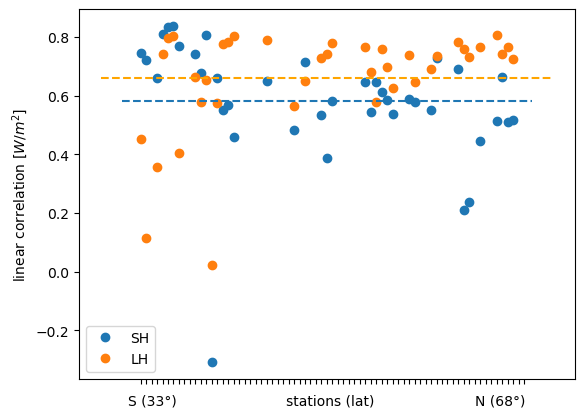

In [15]:
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_cors12[sh_cors12==0]='nan'
lh_cors12[lh_cors12==0]='nan'
ax.plot(x,sh_cors12[np.argsort(meta[:,1])],"o",label="SH")
ax.plot(x,lh_cors12[np.argsort(meta[:,1])],"o",label="LH")
ax.axes.set_ylabel(r'linear correlation [$W/m^2$]')
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend()
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_cors12[sh_cors12!=0]),col='#1f77b4')
abline(0,np.nanmean(lh_cors12[lh_cors12!=0]),col="orange")
#ax.set_ylim((0.37,1))

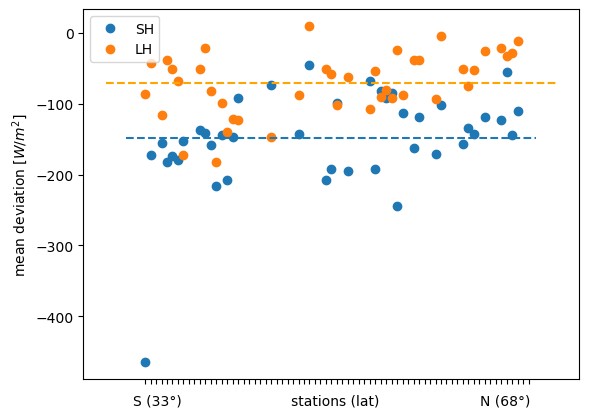

In [16]:
fig,ax = plt.subplots()
x=np.sort(meta[:,1])
sh_md12[sh_md12==0]='nan'
lh_md12[lh_md12==0]='nan'
#sh_md12=sh_md12/6
#lh_md12=lh_md12/6
ax.plot(x,sh_md12[np.argsort(meta[:,1])],"o",label="SH")
ax.plot(x,lh_md12[np.argsort(meta[:,1])],"o",label="LH")
ax.axes.set_ylabel(r'mean deviation [$W/m^2$]')
ax.axes.set_xlabel("S (33°)                         stations (lat)                       N (68°)")
ax.legend()
#ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
abline(0,np.nanmean(sh_md12[sh_md12!=0]),col='#1f77b4')
abline(0,np.nanmean(lh_md12[lh_md12!=0]),col="orange")
#ax.set_ylim((0.37,1))